In [1]:
%matplotlib ipympl
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyobs
# from scipy.stats import norm
import bison

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_seed123456.dat")
# print(data.keys())
# print(data['Configuration 40'].keys())
# print(data['Configuration 40']['Q'].shape)
# print(data['MC History tag-1']['dH'].shape)
# print(data['MC History tag-1']['Acc/Rej'].shape)

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_seed123456.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 134.736 MB at 110.264 MB/s


In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg0 = 0
Nh     = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(*(f" t = {eps_WF * WF_step * i:.2f}" for i in range(Nwf)), sep='\n')

Ntherm0 = 200
print(f"\n Total number of measurements = {Ncnfg0}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg0 * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = {Ntherm0}, i.e. {int(Ntherm0 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {int(5 * MC_step * tauMD * 20)} MDU")
print(f" so we skip {(5 * 20 * MC_step - Ntherm0)*int(tauMD)} MDUs in the current initial data.\n")
print(f" In other words we have to skip {(5 * 20 * MC_step - Ntherm0) // MC_step} measurements.")

skip = (5 * 20 * MC_step - Ntherm0) // MC_step

Ncnfg = Ncnfg0 - skip
print(f" Total configs. = {Ncnfg} (after removing initial due to therm.)")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 t = 0.00
 t = 0.10
 t = 0.20
 t = 0.30
 t = 0.40
 t = 0.50
 t = 0.60
 t = 0.70
 t = 0.80
 t = 0.90
 t = 1.00
 t = 1.10
 t = 1.20
 t = 1.30
 t = 1.40
 t = 1.50
 t = 1.60
 t = 1.70
 t = 1.80
 t = 1.90
 t = 2.00
 t = 2.10
 t = 2.20
 t = 2.30
 t = 2.40
 t = 2.50
 t = 2.60
 t = 2.70
 t = 2.80
 t = 2.90
 t = 3.00
 t = 3.10
 t = 3.20
 t = 3.30
 t = 3.40
 t = 3.50
 t = 3.60
 t = 3.70
 t = 3.80
 t = 3.90
 t = 4.00
 t = 4.10
 t = 4.20
 t = 4.30
 t = 4.40
 t = 4.50
 t = 4.60
 t = 4.70
 t = 4.80
 t = 4.90
 t = 5.00
 t = 5.10
 t = 5.20
 t = 5.30
 t = 5.40
 t = 5.50
 t = 5.60
 t = 5.70
 t = 5.80
 t = 5.90
 t = 6.00

 Total number of 

In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg0, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg0, Nwf, T))
WF_Q     = np.zeros((Ncnfg0, Nwf, T))
Acc      = np.zeros((Nh * Ntraj)) 
dH       = np.zeros((Nh * Ntraj))

for i in range(Ncnfg0):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q'] 

for i in range(Nh):
    Acc[i*Ntraj:(i+1)*Ntraj] = data[f'MC History tag-{i}']['Acc/Rej']
    dH[i*Ntraj:(i+1)*Ntraj]  = data[f'MC History tag-{i}']['dH']

print(f"\n Acceptance rate        =  {np.mean(Acc)*100:.0f} %")
print(f" < |dH| >               =  {np.mean(np.abs(dH)):.3e}\n")


 Acceptance rate        =  95 %
 < |dH| >               =  1.087e-01



In [5]:
### Compute <E_Clov>_t and tau_int ###
t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])
obsEClov = pyobs.observable(description=f'Energy Density at several WF times')
obsEClov.create('Ensemble A', np.sum(WF_EClov[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsEClov /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <E_Clov> = {obsEClov[i]}                 tau_int = {obsEClov[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEClov[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <E_Clov> = 1.955314(16)
                 tau_int = 0.674 +- 0.080

(t = 0.10) :    <E_Clov> = 1.373100(23)
                 tau_int = 0.724 +- 0.086

(t = 0.20) :    <E_Clov> = 0.859945(27)
                 tau_int = 0.893 +- 0.116

(t = 0.30) :    <E_Clov> = 0.548226(27)
                 tau_int = 1.090 +- 0.153

(t = 0.40) :    <E_Clov> = 0.371013(27)
                 tau_int = 1.306 +- 0.196

(t = 0.50) :    <E_Clov> = 0.266815(26)
                 tau_int = 1.521 +- 0.242

(t = 0.60) :    <E_Clov> = 0.201897(25)
                 tau_int = 1.726 +- 0.290

(t = 0.70) :    <E_Clov> = 0.159071(25)
                 tau_int = 1.936 +- 0.341

(t = 0.80) :    <E_Clov> = 0.129380(25)
                 tau_int = 2.143 +- 0.394

(t = 0.90) :    <E_Clov> = 0.107923(25)
                 tau_int = 2.339 +- 0.448

(t = 1.00) :    <E_Clov> = 0.091877(25)
                 tau_int = 2.543 +- 0.505

(t = 1.10) :    <E_Clov> = 0.079532(25)
                 tau_int = 2.741 +- 0.563

(t =

In [6]:
### Compute <Plaq>_t, <E_Plaq>_t and tau_int ###
obsPlaq = pyobs.observable(description=f'Plaquette at several WF times')
obsPlaq.create('Ensemble A', np.sum(WF_Plaq[skip:,:,:], axis=2).flatten(), shape=(Nwf,))
obsPlaq /= V
obsEPlaq = beta * (1.0 - obsPlaq) * D * (D-1) / 2

print(*(f"(t = {t_WF[i]:.2f}) :     <E_Plaq> = {obsEPlaq[i]}                  tau_int = {obsEPlaq[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEPlaq[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :     <E_Plaq> = 14.405786(93)
                  tau_int = 0.571 +- 0.061

(t = 0.10) :     <E_Plaq> = 6.054038(80)
                  tau_int = 0.601 +- 0.064

(t = 0.20) :     <E_Plaq> = 2.619966(60)
                  tau_int = 0.664 +- 0.079

(t = 0.30) :     <E_Plaq> = 1.279857(48)
                  tau_int = 0.863 +- 0.112

(t = 0.40) :     <E_Plaq> = 0.713749(40)
                  tau_int = 1.085 +- 0.152

(t = 0.50) :     <E_Plaq> = 0.446664(35)
                  tau_int = 1.320 +- 0.198

(t = 0.60) :     <E_Plaq> = 0.306172(33)
                  tau_int = 1.547 +- 0.260

(t = 0.70) :     <E_Plaq> = 0.224827(31)
                  tau_int = 1.777 +- 0.313

(t = 0.80) :     <E_Plaq> = 0.173797(30)
                  tau_int = 2.000 +- 0.368

(t = 0.90) :     <E_Plaq> = 0.139634(29)
                  tau_int = 2.214 +- 0.424

(t = 1.00) :     <E_Plaq> = 0.115540(29)
                  tau_int = 2.432 +- 0.483

(t = 1.10) :     <E_Plaq> = 0.097828(28)
                  tau_i

In [7]:
### Compute <Q>_t and tau_int ###
obsQ = pyobs.observable(description=f'Topological charge at several WF times')
obsQ.create('Ensemble A', np.sum(WF_Q[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsQ /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <Q> = {obsQ[i]}                 tau_int = {obsQ[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q> = -0.21(20)
                 tau_int = 0.678 +- 0.080

(t = 0.10) :    <Q> = -0.51(43)
                 tau_int = 5.170 +- 1.372

(t = 0.20) :    <Q> = -0.73(76)
                 tau_int = 17.187 +- 7.298

(t = 0.30) :    <Q> = -0.86(94)
                 tau_int = 21.810 +- 10.091

(t = 0.40) :    <Q> = -1.0(1.0)
                 tau_int = 23.107 +- 10.900

(t = 0.50) :    <Q> = -1.0(1.1)
                 tau_int = 23.501 +- 11.156

(t = 0.60) :    <Q> = -1.1(1.2)
                 tau_int = 23.653 +- 11.228

(t = 0.70) :    <Q> = -1.1(1.2)
                 tau_int = 23.708 +- 11.255

(t = 0.80) :    <Q> = -1.1(1.2)
                 tau_int = 23.695 +- 11.319

(t = 0.90) :    <Q> = -1.1(1.2)
                 tau_int = 23.714 +- 11.257

(t = 1.00) :    <Q> = -1.1(1.3)
                 tau_int = 23.697 +- 11.249

(t = 1.10) :    <Q> = -1.2(1.3)
                 tau_int = 23.678 +- 11.240

(t = 1.20) :    <Q> = -1.2(1.3)
                 tau_int = 23.659 +- 11.231

(t =

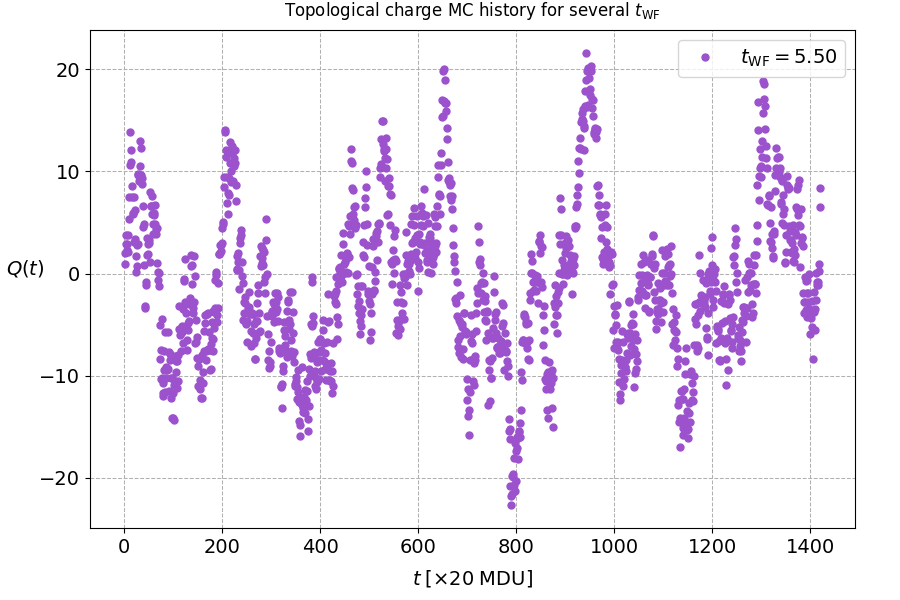

In [13]:
### MC history of Q for several tWF ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(f"Topological charge MC history for several $t_{{\mathrm{{WF}}}}$", pad=10)
ax.set_ylabel(r"$Q(t)$", labelpad=10, rotation=0, fontsize=fsize)
ax.set_xlabel(rf'$t \; [\times {int(MC_step * tauMD)} \; \mathrm{{MDU}}]$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.grid(linestyle = '--', linewidth = 0.75)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])

tWF = np.array([1.50, 3.50, 5.50])
i0  = (tWF / (eps_WF * WF_step)).astype(int)
# ax.plot(np.arange(1, Ncnfg0+1), np.sum(WF_Q[:, i0[0], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[0]}$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
# ax.plot(np.arange(1, Ncnfg0+1), np.sum(WF_Q[:, i0[1], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[1]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#2bad4e', linewidth=1.0)
ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[skip:, i0[2], :], axis=1)/V, label=rf'$t_{{\mathrm{{WF}}}} = {tWF[2]:.2f}$', linestyle='', marker='o' , markersize=5.0, color='#9b52cc', linewidth=1.0)

#ax.axvspan(0.0, skip, alpha=0.5, color='#808080')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

[-20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5
  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5
   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5
  15.5  16.5  17.5  18.5  19.5  20.5]


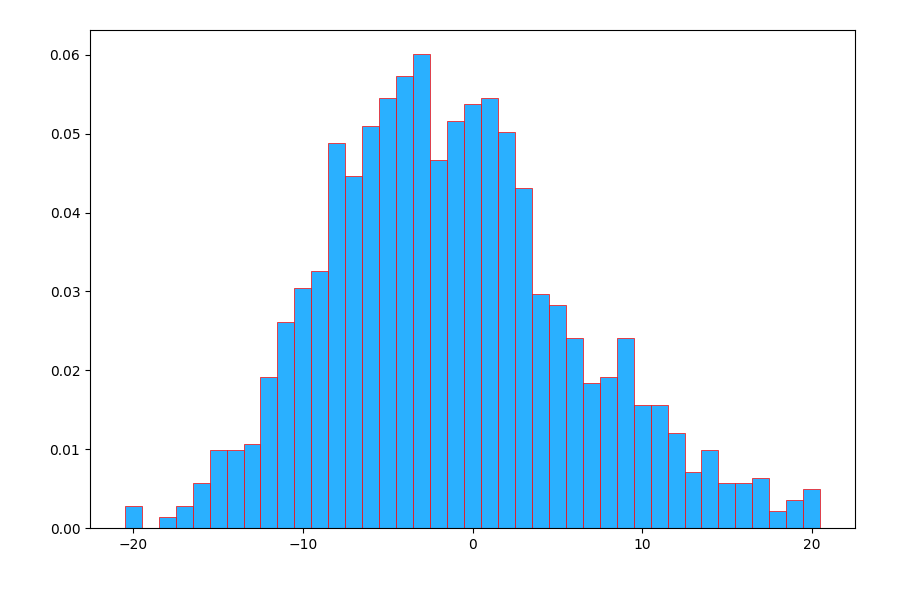

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))

binwidth = 1.0
data = (np.sum(WF_Q[skip:,i0,:], axis=1)/V).copy()
counts, bins, obj = ax.hist(data, density=True, bins=np.arange(-20.5, 20.5 + binwidth, binwidth), facecolor = '#2ab0ff', edgecolor='red', linewidth=0.5)
print(bins)

# mu, sigma = norm.fit(np.sum(WF_Q[Ntherm0:,i0,:], axis=1)/V)
# best_fit_line = norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line)
# print(mu, np.sqrt(sigma))

In [19]:
### Compute <Q^2>_t and tau_int ###
obsQ2 = pyobs.observable(description=f'Topological susceptibility at several WF times')
obsQ2.create('Ensemble A', ((np.sum(WF_Q[skip:,:,:], axis=2))**2).flatten(), shape=(Nwf,))
obsQ2 /= V**2

print(*(f"(t = {t_WF[i]:.2f}) :    <Q^2> = {obsQ2[i]}                 tau_int = {obsQ2[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ2[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q^2> = 41.6(1.6)
                 tau_int = 0.582 +- 0.062

(t = 0.10) :    <Q^2> = 25.7(1.2)
                 tau_int = 0.934 +- 0.121

(t = 0.20) :    <Q^2> = 24.6(2.9)
                 tau_int = 5.381 +- 1.456

(t = 0.30) :    <Q^2> = 29.5(4.1)
                 tau_int = 7.337 +- 2.237

(t = 0.40) :    <Q^2> = 34.7(5.0)
                 tau_int = 7.931 +- 2.490

(t = 0.50) :    <Q^2> = 38.7(5.6)
                 tau_int = 8.095 +- 2.578

(t = 0.60) :    <Q^2> = 41.8(6.1)
                 tau_int = 8.241 +- 2.624

(t = 0.70) :    <Q^2> = 44.0(6.4)
                 tau_int = 8.143 +- 2.629

(t = 0.80) :    <Q^2> = 45.8(6.7)
                 tau_int = 8.172 +- 2.638

(t = 0.90) :    <Q^2> = 47.1(6.9)
                 tau_int = 8.178 +- 2.640

(t = 1.00) :    <Q^2> = 48.2(7.1)
                 tau_int = 8.170 +- 2.638

(t = 1.10) :    <Q^2> = 49.1(7.2)
                 tau_int = 8.157 +- 2.633

(t = 1.20) :    <Q^2> = 49.9(7.3)
                 tau_int = 8.140 +- 2.628


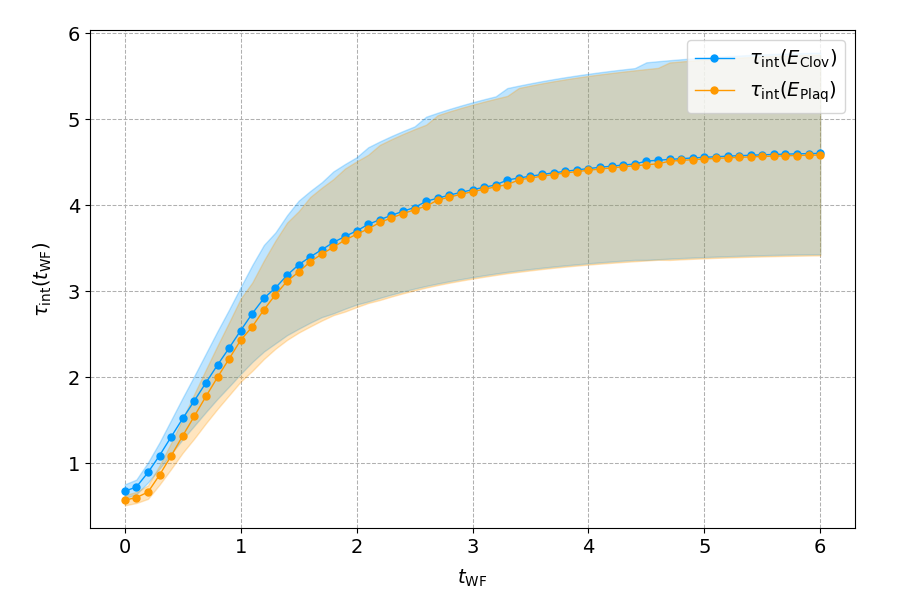

In [22]:
tau_EClov = np.array([np.squeeze(obsEClov[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_EPlaq = np.array([np.squeeze(obsEPlaq[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_Q     = np.array([np.squeeze(obsQ[i].tauint()['Ensemble A'],     axis=1) for i in range(Nwf)])
tau_Q2    = np.array([np.squeeze(obsQ2[i].tauint()['Ensemble A'],    axis=1) for i in range(Nwf)])


fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_ylabel(r"$\tau_\mathrm{int}(t_\mathrm{WF})$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(t_WF, tau_EClov[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Clov})$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF, tau_EClov[:,0] + std * tau_EClov[:,1], tau_EClov[:,0] - std * tau_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF, tau_EPlaq[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Plaq})$', linestyle='-', marker='o' , markersize=5.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF, tau_EPlaq[:,0] + std * tau_EPlaq[:,1], tau_EPlaq[:,0] - std * tau_EPlaq[:,1], alpha=.25, color='#ff9900')
# ax.plot(t_WF, tau_Q[:,0], label=r'$\tau_\mathrm{int}(Q)$', linestyle='-', marker='o' , markersize=5.0, color='#a151bf', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q[:,0] + std * tau_Q[:,1], tau_Q[:,0] - std * tau_Q[:,1], alpha=.25, color='#a151bf')
# ax.plot(t_WF, tau_Q2[:,0], label=r'$\tau_\mathrm{int}(Q^2)$', linestyle='-', marker='o' , markersize=5.0, color='#d13e27', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q2[:,0] + std * tau_Q2[:,1], tau_Q2[:,0] - std * tau_Q2[:,1], alpha=.25, color='#d13e27')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [23]:
### Compute t^2<E> for each t_WF ###
obs_t2EClov = (t_WF[1:]**2) * obsEClov[1:]
obs_t2EPlaq = (t_WF[1:]**2) * obsEPlaq[1:]
print("\n")
print(*(f"(t = {t_WF[i+1]:.2f}) :   t^2 <E_Clov> = {obs_t2EClov[i]}               t^2 <E_Plaq> = {obs_t2EPlaq[i]}\n" for i in range(WF_evol // WF_step)), sep='')



(t = 0.10) :   t^2 <E_Clov> = 0.01373100(23)
               t^2 <E_Plaq> = 0.06054038(80)

(t = 0.20) :   t^2 <E_Clov> = 0.0343978(11)
               t^2 <E_Plaq> = 0.1047986(24)

(t = 0.30) :   t^2 <E_Clov> = 0.0493403(24)
               t^2 <E_Plaq> = 0.1151871(43)

(t = 0.40) :   t^2 <E_Clov> = 0.0593621(43)
               t^2 <E_Plaq> = 0.1141999(64)

(t = 0.50) :   t^2 <E_Clov> = 0.0667037(65)
               t^2 <E_Plaq> = 0.1116659(89)

(t = 0.60) :   t^2 <E_Clov> = 0.0726830(92)
               t^2 <E_Plaq> = 0.110222(12)

(t = 0.70) :   t^2 <E_Clov> = 0.077945(12)
               t^2 <E_Plaq> = 0.110165(15)

(t = 0.80) :   t^2 <E_Clov> = 0.082803(16)
               t^2 <E_Plaq> = 0.111230(19)

(t = 0.90) :   t^2 <E_Clov> = 0.087417(20)
               t^2 <E_Plaq> = 0.113103(24)

(t = 1.00) :   t^2 <E_Clov> = 0.091877(25)
               t^2 <E_Plaq> = 0.115540(29)

(t = 1.10) :   t^2 <E_Clov> = 0.096234(30)
               t^2 <E_Plaq> = 0.118372(34)

(t = 1.20) :   t^2 <E_Clov> 

In [24]:
### Calculation of t_0 for both E_Clov and E_Plaq ###
eps = 0.01

x, dx = obs_t2EClov.error()
idx_x = np.squeeze(np.where((x < 0.3 + eps) & (x > 0.3 - eps)), axis=0)
print(f"\nE_Clov  :")
print(f"                  E_Clov  =  {x[idx_x]},") 
print(f"                  t_WF    =  {t_WF[idx_x+1]},\n") # recall t_WF starts from 0.0, whose corresponding value is not neither in obs_t2EClov nor in obs_t2EPlaq.
interp_Clov = pyobs.interpolate(t_WF[idx_x+1], obs_t2EClov[idx_x])
obs_t0EClov = interp_Clov.solve(0.3, bracket=[t_WF[(idx_x+1)[0]], t_WF[(idx_x+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EClov}")
t0_EClov, dt0_EClov = np.squeeze(obs_t0EClov.error(), axis=1)

y, dy = obs_t2EPlaq.error()
idx_y = np.squeeze(np.where((y < 0.3 + eps) & (y > 0.3 - eps)), axis=0)
print(f"E_Plaq  :")
print(f"                  E_Plaq  =  {y[idx_y]},") 
print(f"                  t_WF    =  {t_WF[idx_y+1]},\n")
interp_Plaq = pyobs.interpolate(t_WF[idx_y+1], obs_t2EPlaq[idx_y])
obs_t0EPlaq = interp_Plaq.solve(0.3, bracket=[t_WF[(idx_y+1)[0]], t_WF[(idx_y+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EPlaq}")
t0_EPlaq, dt0_EPlaq = np.squeeze(obs_t0EPlaq.error(), axis=1)


E_Clov  :
                  E_Clov  =  [0.29454139 0.29979935 0.30508742],
                  t_WF    =  [5.4 5.5 5.6],

                  interpolation  --->  t0 = 5.504(11)

E_Plaq  :
                  E_Plaq  =  [0.29304529 0.29836758 0.30372429 0.3091151 ],
                  t_WF    =  [5.  5.1 5.2 5.3],

                  interpolation  --->  t0 = 5.131(10)



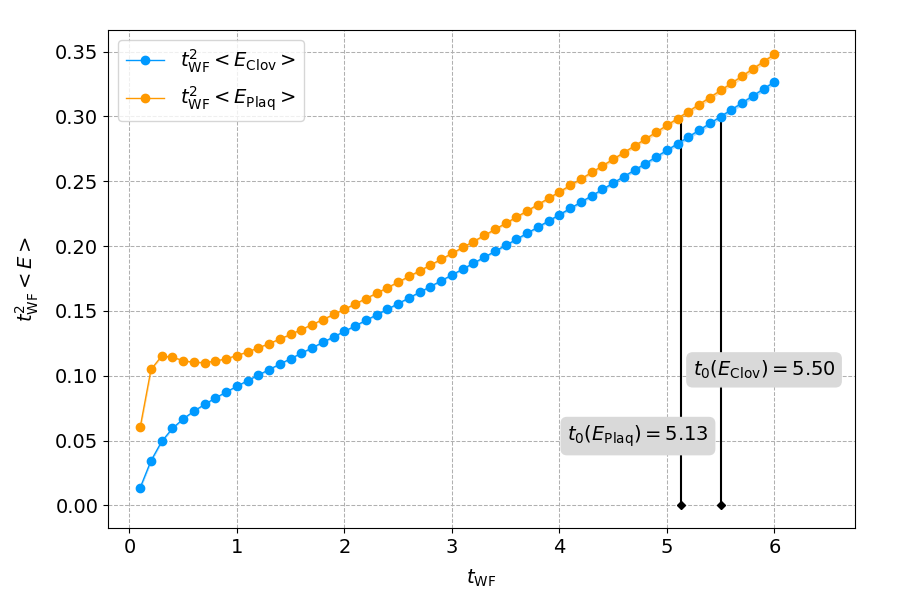

In [27]:
t2EClov = np.array([np.squeeze(obs_t2EClov[i].error(), axis=1) for i in range(WF_evol // WF_step)])
t2EPlaq = np.array([np.squeeze(obs_t2EPlaq[i].error(), axis=1) for i in range(WF_evol // WF_step)])

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

fsize = 14
std = 2.0
box = dict(boxstyle="round", color='#d9d9d9')

ax.set_ylabel(r"$t_\mathrm{WF}^2 <E>$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

ax.vlines(x = t0_EClov, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EClov, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EClov, 0.0, xerr=std*dt0_EClov, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Clov}}) = {t0_EClov:.2f}$", (t0_EClov, 0.10), xytext=(t0_EClov+0.4, 0.10), ha='center', bbox=box, fontsize=fsize)
ax.vlines(x = t0_EPlaq, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EPlaq, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EPlaq, 0.0, xerr=std*dt0_EPlaq, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Plaq}}) = {t0_EPlaq:.2f}$", (t0_EPlaq, 0.10), xytext=(t0_EPlaq-0.4, 0.05), ha='center', bbox=box, fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.2, 6.75])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.plot(t_WF[1:], t2EClov[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Clov}>$', linestyle='-', marker='o' , markersize=6.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EClov[:,0] + std * t2EClov[:,1], t2EClov[:,0] - std * t2EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF[1:], t2EPlaq[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Plaq}>$', linestyle='-', marker='o' , markersize=6.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EPlaq[:,0] + std * t2EPlaq[:,1], t2EPlaq[:,0] - std * t2EPlaq[:,1], alpha=.25, color='#ff9900')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig('t0E.pdf')

In the python script I measure $\widetilde{q}(t) = \sum_{\mathbf{x}}q(t, \mathbf{x})$ using the function <code>topol_charge(..., field=True)</code> (indeed the function does not include the factor $\times 1/V$). Therefore what we call <b>Topological Charge</b> is
$$
    Q = \frac{1}{V} \sum_t \langle \widetilde{q}(t) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(0, \mathrm{0}) \rangle \equiv \langle q \rangle \, ,
$$
where we exploited translational invariance in the third step. Thus, we have to average over all MC configurations, sum over $t$ and divide by $V$ to compute the Topological Charge. 

Similarly, the calculation of the <b>Topological Susceptibility</b> $\chi = \frac{Q^2}{V}$ is straightforward
\begin{align*}
    \chi &= \frac{1}{V^2} \sum_{t, t'} \langle \widetilde{q}(t) \widetilde{q}(t') \rangle = \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{x}'} \langle q(t, \mathrm{x}) q(t', \mathrm{x}') \rangle \\
    &= \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{z}} \langle q(t, \mathrm{z}) q(0, \mathrm{0}) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) q(0, \mathrm{0}) \rangle \, .
\end{align*}

Equivalently, we can construct an estimator with $T$ more statistics as follows:
$$
    \left\langle \frac{1}{T} \sum_{t'} \widetilde{q}(t') \widetilde{q}(t+t') \right\rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t', \mathbf{x}) q(t+t', \mathbf{y}) \rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t, |\mathbf{x} - \mathbf{y}|) q(0,0) \rangle = \frac{V}{T} \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ;
$$
therefore if we define 
$$
    C(t) \equiv \frac{T}{V} \left\langle \frac{1}{T} \sum_{t'} \widetilde{q}(t') \widetilde{q}(t+t') \right\rangle = \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ,
$$
we can eventually extract the topological susceptibility as 
$$
    \chi = \frac{1}{V} \sum_t C(t) \, .
$$

In [26]:
### Compute correlator <q(t)q(0)> for a given tWF. ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
QQ = np.zeros((Ncnfg0, T))
for tp in range(T):
    QQ[:,tp] = np.mean(WF_Q[:,i0,:] * np.roll(WF_Q[:,i0,:], -tp, axis=1), axis=1) 

obsCorr_QQ = pyobs.observable(description=f'Correlator <q(t)q(0)> for tWF = {t0}')
obsCorr_QQ.create('Ensemble A', QQ[skip:,:].flatten(), shape=(T,))
obsCorr_QQ *= T/V
obsCorr_QQ -= pyobs.tile(obsQ[i0], T) * V / T
#print(obsCorr_QQ)
#print(obsQ[i0])

13208882(434469)	12350905(429755)	10191748(419240)	7556716(405779)	5117646(391710)	3213990(380374)	1906681(372554)	1101535(365815)	656232(359622)	440257(354172)	357007(348732)	344715(345377)	367769(339618)	406467(332572)	450592(325267)	498143(319396)	553957(316765)	623401(318542)	705540(324611)	790112(333617)	858868(343611)	891815(354364)	877599(362082)	819993(362966)	734131(359113)	636130(354578)	535551(355611)	436252(363325)	342631(379436)	261632(405008)	199587(430793)	160895(449139)	147802(457659)	160895(449139)	199587(430793)	261632(405008)	342631(379436)	436252(363325)	535551(355611)	636130(354578)	734131(359113)	819993(362966)	877599(362082)	891815(354364)	858868(343611)	790112(333617)	705540(324611)	623401(318542)	553957(316765)	498143(319396)	450592(325267)	406467(332572)	367769(339618)	344715(345377)	357007(348732)	440257(354172)	656232(359622)	1101535(365815)	1906681(372554)	3213990(380374)	5117646(391710)	7556716(405779)	10191748(419240)	12350905(429755)

-1.3(1.4)



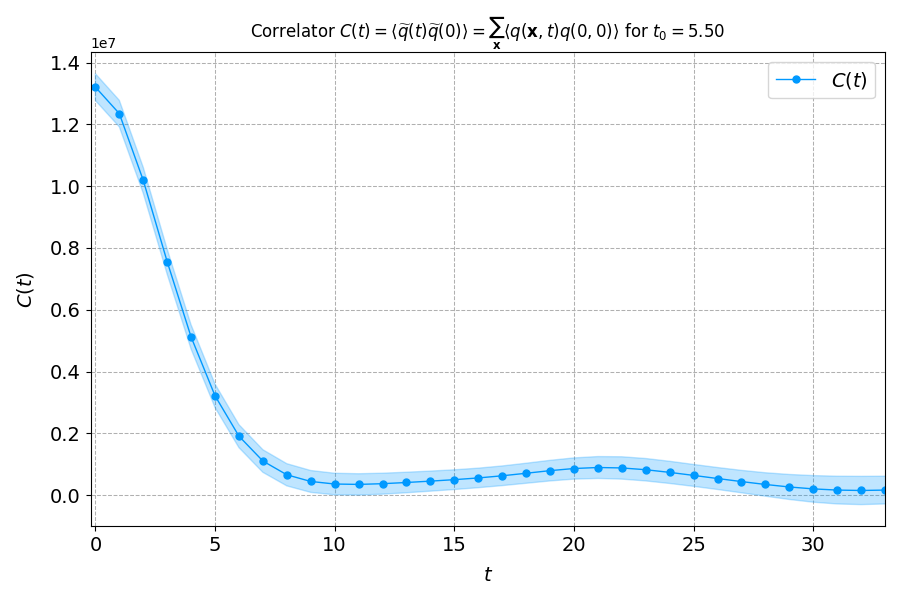

In [17]:
Ct, dCt = obsCorr_QQ.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \langle \widetilde{{q}}(t) \widetilde{{q}}(0) \rangle = \sum_{{\mathbf{{x}}}} \langle q(\mathbf{{x}}, t) q(0,0) \rangle$ for $t_0 = {t0:.2f}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [18]:
Tsym = T // 2

obsChi_sum  = 0
Chi_sum     = np.zeros((2, Tsym + 1)) # error and central value

Chi_sum[0, 0]  = obsCorr_QQ[0].error()[0][0]
Chi_sum[1, 0]  = obsCorr_QQ[0].error()[1][0]
for t in range(1, Tsym + 1):
    obsChi_sum  += 2.0 * obsCorr_QQ[t]
    Chi_sum[0, t] = obsChi_sum.error()[0][0]
    Chi_sum[1, t] = obsChi_sum.error()[1][0]
Chi_sum /= V

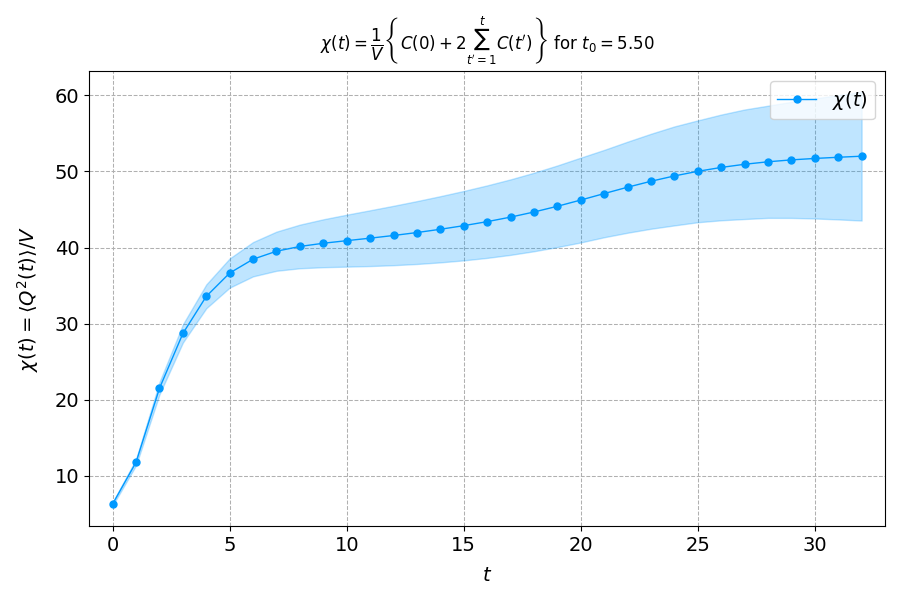

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"$\chi(t) = \dfrac{{1}}{{V}} \left \{{ C(0) + 2\sum_{{t'=1}}^t C(t') \right \}}$ for $t_0 = {t0:.2f}$", pad=15)
ax.set_ylabel(r"$\chi(t) = \langle Q^2(t) \rangle / V$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-1, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tsym + 1), Chi_sum[0], label=r'$\chi(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tsym + 1), Chi_sum[0] + std * Chi_sum[1], Chi_sum[0] - std * Chi_sum[1], alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [20]:
t0 = 5.5
i0 = int(t0 / (eps_WF * WF_step))
EEClov = np.zeros((Ncnfg0, T))
for tp in range(T):
    EEClov[:,tp] = np.mean(WF_EClov[:,i0,:] * np.roll(WF_EClov[:,i0,:], -tp, axis=1), axis=1)

obsCorr_EEClov = pyobs.observable(description=f'Correlator <E(t)E(0)> for tWF = {t0}')
obsCorr_EEClov.create('Ensemble A', EEClov[skip:,:].flatten(), shape=(T,))
obsCorr_EEClov *= T/V 
obsCorr_EEClov -= pyobs.tile(obsEClov[i0]*obsEClov[i0], T) * V / T

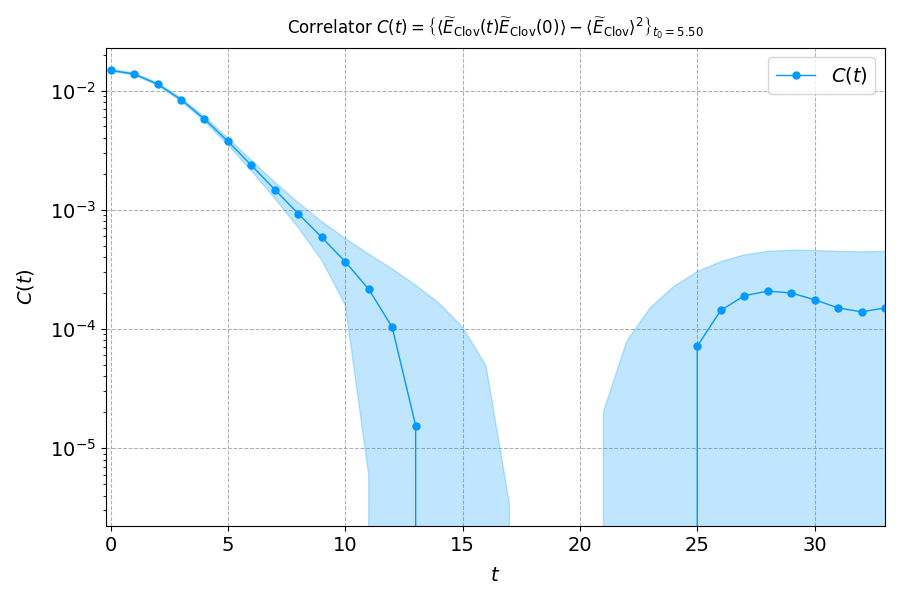

In [21]:
Ct, dCt = obsCorr_EEClov.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}_\mathrm{{Clov}}(t) \widetilde{{E}}_\mathrm{{Clov}}(0) \rangle - \langle \widetilde{{E}}_\mathrm{{Clov}} \rangle^2 \right \}}_{{t_0 = {t0:.2f}}}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
ax.set_yscale('log')

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [22]:
Tmin = 0
Tmax = T // 2
Ct_mass   = np.zeros(Tmax - Tmin)
dCt_mass  = np.zeros(Tmax - Tmin)

for i in range(Tmax - Tmin):
    eff_mass  = pyobs.log(obsCorr_EEClov[i] / obsCorr_EEClov[i+1])
    Ct_mass[i]   = eff_mass.error()[0][0]
    dCt_mass[i]  = eff_mass.error()[1][0]

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


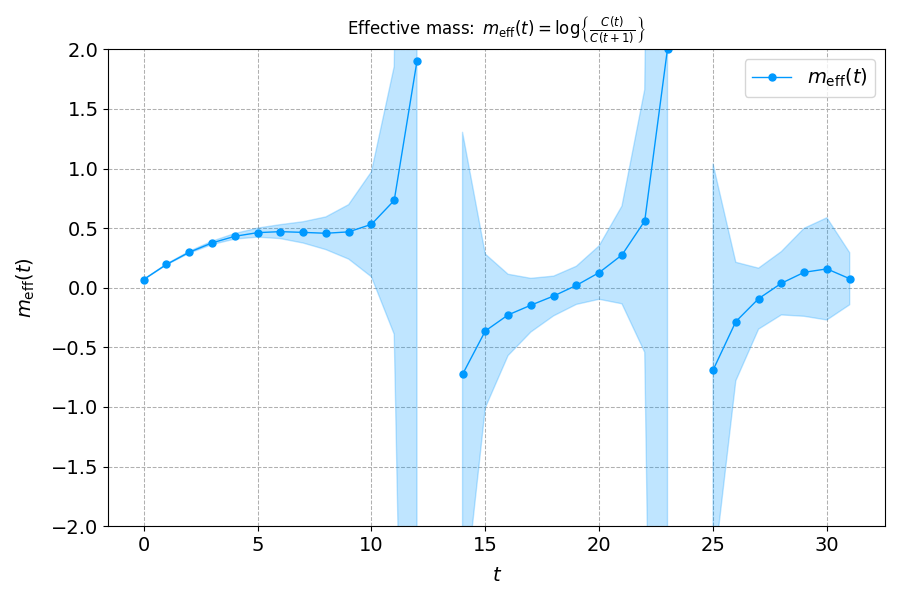

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Effective mass: $\,m_\mathrm{{eff}}(t) = \log \left \{{ \frac{{C(t)}}{{C(t+1)}} \right \}}$", pad=10)
ax.set_ylabel(r"$m_{\mathrm{eff}}(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-0.2, 12])
plt.ylim([-2, 2])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tmin, Tmax), Ct_mass, label=r'$m_{\mathrm{eff}}(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tmin, Tmax), Ct_mass + std * dCt_mass, Ct_mass - std * dCt_mass, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [24]:
### Compute autocorrelation functions for each <E_Clov>_t and <E_Plaq>_t ###
gammaEClov = []
gammaEPlaq = []
gammaQ     = []
gammaQ2    = []
if (obsEClov.shape[0] == Nwf) and (obsEPlaq.shape[0] == Nwf) \
    and (obsQ.shape[0] == Nwf) and (obsQ2.shape[0] == Nwf):
    for i in range(Nwf): 
        norm, gamma = obsEClov[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEClov.append(gamma)
        norm, gamma = obsEPlaq[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEPlaq.append(gamma)
        norm, gamma = obsQ[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ.append(gamma)
        norm, gamma = obsQ2[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ2.append(gamma)
else:
    print(f"Check observables shapes !")

norm, gamma_t0EClov = obs_t0EClov.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EClov = gamma_t0EClov / norm 

norm, gamma_t0EPlaq = obs_t0EPlaq.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EPlaq = gamma_t0EPlaq / norm 

gammaEClov = np.array(gammaEClov)
gammaEPlaq = np.array(gammaEPlaq)
gammaQ     = np.array(gammaQ)
gammaQ2    = np.array(gammaQ2)

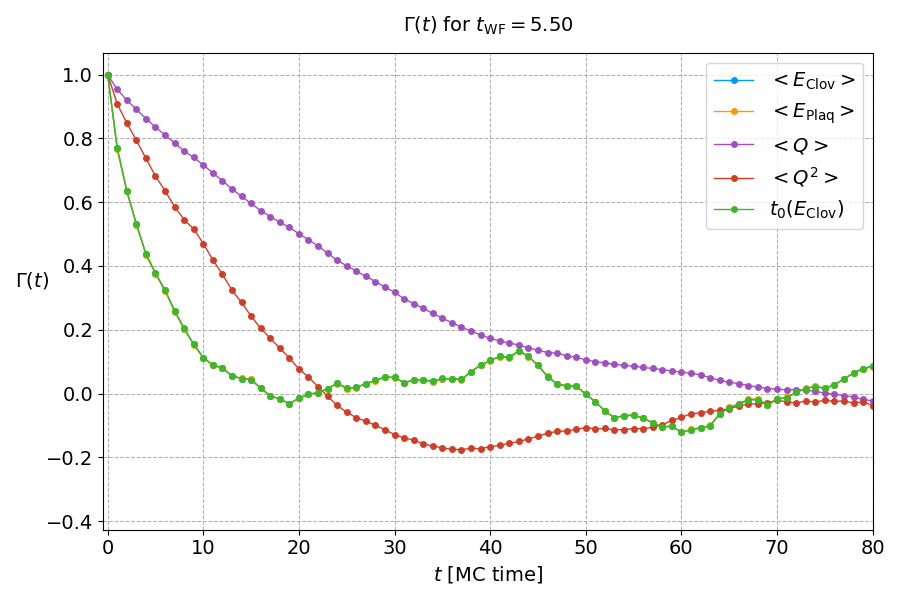

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.plot(np.arange(tmax), gammaEClov[i,:tmax]/gammaEClov[i,0], color='#0099ff', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Clov}}>$')
ax.plot(np.arange(tmax), gammaEPlaq[i,:tmax]/gammaEPlaq[i,0], color='#ff9900', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Plaq}}>$')
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q>$')
ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q^2>$')
ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
ax.set_xlabel(r'$t$ [MC time]', fontsize=fsize)
ax.set_ylabel(r'$\Gamma(t)$', rotation=0, labelpad=10, fontsize=fsize)
ax.legend(loc='best', fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.5, 80])
#plt.ylim([1e-2, 1e1])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log', base=10)
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

Bounding Method application

In [26]:
### Bounding Method ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
tau0 = obsQ[i0].tauint()['Ensemble A'][0][0]
print(f"\n tau_slow for bounding = {tau0:.2f}, which is {int(tau0 * tauMD * MC_step)} MDU\n")

Tmax = 40
for t in range(Tmax):
   # print(f" t0     :    tau_eff(W={t}) = {1.0 / np.log(gamma_t0EClov[t] / gamma_t0EClov[t+1]):.3f},")
   print(f" Q      :    tau_eff(W={t}) = {1.0 / np.log(gammaQ[i0, t] / gammaQ[i0, t+1]):.3f},")
   # print(f" Q^2   :    tau_eff(W={t}) = {1.0 / np.log(gammaQ2[i0, t] / gammaQ2[i0, t+1]):.3f},")
print("\n")


 tau_slow for bounding = 23.48, which is 469 MDU

 Q      :    tau_eff(W=0) = 20.849,
 Q      :    tau_eff(W=1) = 28.332,
 Q      :    tau_eff(W=2) = 30.703,
 Q      :    tau_eff(W=3) = 30.679,
 Q      :    tau_eff(W=4) = 31.213,
 Q      :    tau_eff(W=5) = 33.450,
 Q      :    tau_eff(W=6) = 31.475,
 Q      :    tau_eff(W=7) = 30.886,
 Q      :    tau_eff(W=8) = 37.637,
 Q      :    tau_eff(W=9) = 30.772,
 Q      :    tau_eff(W=10) = 28.298,
 Q      :    tau_eff(W=11) = 28.298,
 Q      :    tau_eff(W=12) = 25.030,
 Q      :    tau_eff(W=13) = 27.189,
 Q      :    tau_eff(W=14) = 27.231,
 Q      :    tau_eff(W=15) = 26.203,
 Q      :    tau_eff(W=16) = 30.450,
 Q      :    tau_eff(W=17) = 30.024,
 Q      :    tau_eff(W=18) = 33.759,
 Q      :    tau_eff(W=19) = 24.850,
 Q      :    tau_eff(W=20) = 27.013,
 Q      :    tau_eff(W=21) = 23.388,
 Q      :    tau_eff(W=22) = 20.889,
 Q      :    tau_eff(W=23) = 18.615,
 Q      :    tau_eff(W=24) = 23.874,
 Q      :    tau_eff(W=25) = 23.45

In [27]:
def Cbar_W(gamma, W):
    """ returns Cbar(W) = gamma(0) + 2*sum_{i=1}^W gamma(i) """
    return gamma[0] + 2.0 * np.sum(gamma[1:W+1])

def sys_err(gammaW, W, tau_slow, tau_effW):
    """ returns the systematic effect coming from the truncation 
    of the sum of the autocorrelation function up to a window W. 
    This quantity is computed in a data-driven way, i.e. the error is 
    is given by a difference between the bounds (see eqs 4.2.1 master thesis),
    namely
        2*sum_{i=W+1}^infty{ gamma_upp(t|W, tau0) - gamma_low(t|W, tau_eff^W) }
    """
    cutoff_low = int(np.ceil(3.0 * tau_effW * np.log(10)))
    cutoff_upp = int(np.ceil(3.0 * tau_slow * np.log(10)))
    if cutoff_upp < W:
        cutoff_upp *= 2
    if cutoff_low < W:
        cutoff_low *= 2
    sum_upp = np.sum(np.exp(- (np.arange(cutoff_upp - W) + 1) / tau_slow))
    sum_low = np.sum(np.exp(- (np.arange(cutoff_low - W) + 1) / tau_effW))
    return 2.0 * gammaW * (sum_upp - sum_low)

In [32]:
########################
### Bounding routine ###
########################
# gamma is a numpy array of size Nconf containing the values of the
# autocorrelation function for a given observable. 
def bounding(gamma, tau_slow, cnfg, M=2.0):
    W = 0
    # Assume first W is ok by default:
    arg_o     = gamma[W] / gamma[W + 1]
    tau_eff_o = 1.0 / np.log(arg_o)
    LHS_o     = np.sqrt((4.0 * W + 2.0) / cnfg)
    cbar_o    = Cbar_W(gamma, W)      # this is only gamma[0] for W = 0
    RHS_o     = M * sys_err(gamma[W], W, tau_slow, tau_eff_o) / cbar_o
    print(f"\n slowest mode = {tau_slow}\n")
    print(f" W = {W},  tau_eff^W = {tau_eff_o},  LHS - RHS = {LHS_o - RHS_o},  err = {np.sqrt(cbar_o/cnfg)}")
    W = 1
    while W < cnfg:
        arg_n = gamma[W] / gamma[W + 1]
        if (arg_n <= 1.0) or (1.0/np.log(arg_n) >= tau_slow):
            arg_n = arg_o # uses the last tau_eff that is ok
            
        tau_eff_n = 1.0 / np.log(arg_n)
        LHS_n     = np.sqrt((4.0 * W + 2.0) / cnfg)
        cbar_n    = Cbar_W(gamma, W)
        RHS_n     = M * sys_err(gamma[W], W, tau_slow, tau_eff_n) / cbar_n
        
        print(f" W = {W},  tau_eff^W = {tau_eff_n},  LHS - RHS = {LHS_n - RHS_n},  err = {np.sqrt(cbar_n/cnfg)}")

        if ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n >= 0.0)): # change of sign with current W --> return new.
            return W
        elif ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n < 0.0)): # not yet change of sign. 
            arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
            W += 1
        else: # both differences are positive
            print(f"Both differences at {W} and {W+1} are positive.")
            if (LHS_o - RHS_o) > (LHS_n - RHS_n):
                arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
                W += 1
            else:
                return W-1
#gamma = gamma_t0EClov              
#gamma = gammaQ[i0, :]
gamma = gammaQ2[i0, :]

W_bnd = bounding(gamma, 4*tau0, Ncnfg)
    
print(f"\n W_bnd     = {W_bnd}")
W = W_bnd
print(f" err(W={W}) = {np.sqrt(Cbar_W(gamma, W)/Ncnfg)}")



 slowest mode = 93.91082759608696

 W = 0,  tau_eff^W = 10.34987970182114,  LHS - RHS = -333.8426553309055,  err = 2.0740238674971025
 W = 1,  tau_eff^W = 14.616341403553749,  LHS - RHS = -102.09477599655358,  err = 3.4802854859008385
 W = 2,  tau_eff^W = 15.158016547136656,  LHS - RHS = -59.054305161634595,  err = 4.405301441840191
 W = 3,  tau_eff^W = 13.4612243433153,  LHS - RHS = -41.73569517676232,  err = 5.122039397393045
 W = 4,  tau_eff^W = 12.846253840218408,  LHS - RHS = -31.40723971692482,  err = 5.707451167523082
 W = 5,  tau_eff^W = 14.165751228082172,  LHS - RHS = -24.18392435108385,  err = 6.199993773093305
 W = 6,  tau_eff^W = 12.31943450461381,  LHS - RHS = -20.155477642516882,  err = 6.626092433442606
 W = 7,  tau_eff^W = 13.827610335849249,  LHS - RHS = -16.327379339967713,  err = 6.996012017206502
 W = 8,  tau_eff^W = 18.30608103541039,  LHS - RHS = -13.047608027243358,  err = 7.32336745233245
 W = 9,  tau_eff^W = 10.812891608444058,  LHS - RHS = -12.52568750495363

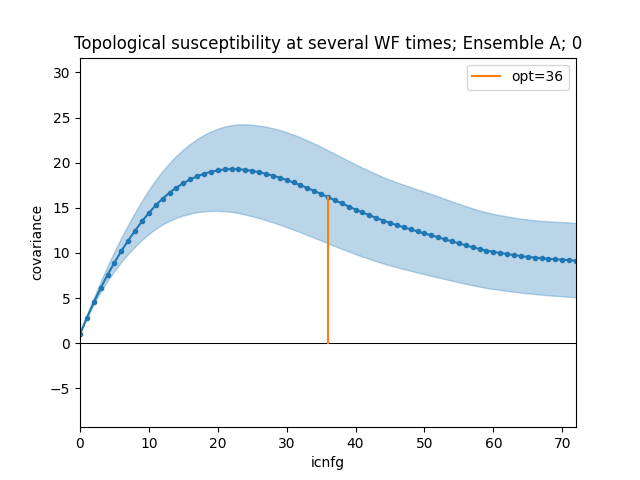

[56.95506716] [8.34337916]


In [33]:
#e, de = obs_t0EClov.error(plot=True)
#e, de = obsQ[i0].error(plot=True)
e, de = obsQ2[i0].error(plot=True)
print(e, de)

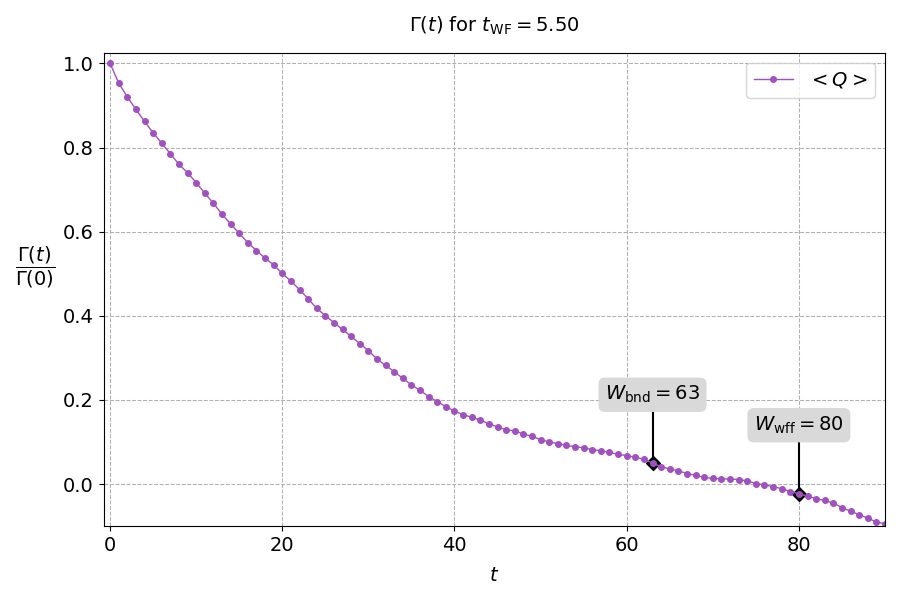

In [36]:
### Bounding plots of W_bnd for the Gammas above ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

### W results: ###
W_bnd_t0, W_wff_t0 = 17, 23
W_bnd_Q,  W_wff_Q  = 63, 80
W_bnd_Q2, W_wff_Q2 = 23, 36 

fsize = 14
box = dict(boxstyle="round", color='#d9d9d9')

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.set_ylabel(r"$\dfrac{\Gamma(t)}{\Gamma(0)}$", labelpad=20, rotation=0, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)



# ### t0(E_clov) ###
# ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
#         marker='o',     linestyle='-',       linewidth='1.5', \
#         markersize=5.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
# ax.scatter(W_bnd_t0, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_t0, ymin = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_t0}$", (W_bnd_t0, 0.40), xytext=(W_bnd_t0-1.3, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_t0, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_t0, ymin = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_t0}$", (W_wff_t0, 0.40), xytext=(W_wff_t0+1.3, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.2, W_wff_t0+4])



### Q ###
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q>$')
ax.scatter(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0], color='black', marker='D', s=50)
ax.vlines(x = W_bnd_Q, ymin = gammaQ[i,W_bnd_Q]/gammaQ[i,0], ymax = gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q}$", (W_bnd_Q, 0.40), xytext=(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
ax.scatter(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0], color='black', marker='D', s=50)
ax.vlines(x = W_wff_Q, ymin = gammaQ[i,W_wff_Q]/gammaQ[i,0], ymax = gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q}$", (W_wff_Q, 0.40), xytext=(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
plt.xlim([-0.75, W_wff_Q + 10])
plt.ylim([-0.1, 1.025])



# ### Q^2 ###
# ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle Q^2 \rangle$')
# ax.scatter(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Q2, ymin = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q2}$", (W_bnd_Q2, 0.40), xytext=(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Q2, ymin = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q2}$", (W_wff_Q2, 0.40), xytext=(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, W_wff_Q2+10])
# # plt.ylim([-0.1, 1.025])




plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.legend(loc='best', fontsize=fsize)
fig.tight_layout()
#plt.savefig('t0E.pdf')